In [5]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms as T
from scipy.signal import cheby2, sosfilt
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# === Load and Preprocess Image === #
def load_image(path, resize_to=(1024, 1024)):
    """
    Loads an image from disk and resizes it to a larger size for more meaningful frequency operations.
    """
    transform = T.Compose([
        T.ToTensor(),  # Converts to [0, 1] and shape (C, H, W)
    ])
    image = Image.open(path).convert("RGB")
    return transform(image)



# === Save Image === #
def save_tensor_image(tensor, filename):
    """
    Saves a torch tensor image (C, H, W) to disk.
    """
    to_pil = T.ToPILImage()
    if tensor.dim() == 4:
        tensor = tensor.squeeze(0)
    img = to_pil(torch.clamp(tensor.cpu(), 0, 1))
    img.save(filename)


# === Frequency Filtering Module === #
def chebyshev_lowpass_filter(image, cutoff=0.4, fs=1.0, order=4, rs=40):
    """
    Applies a Chebyshev Type II lowpass filter to remove high frequencies.
    Filters each row and column separately for each channel.
    Expects image shape (C, H, W) as NumPy array or tensor.
    """
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()

    C, H, W = image.shape
    filtered = np.zeros_like(image)

    for c in range(C):
        sos = cheby2(order, rs, cutoff, btype='low', output='sos', fs=fs)

        # Filter each row (axis=1)
        for i in range(H):
            filtered[c, i, :] = sosfilt(sos, image[c, i, :])

        # Filter each column (axis=2)
        for j in range(W):
            filtered[c, :, j] = sosfilt(sos, filtered[c, :, j])

    return torch.tensor(filtered, dtype=torch.float32)



# === Adaptive Noise Injection in Mid Frequency === #
def adaptive_noise_injection(image, mid_freq_band=(0.1, 0.4), noise_std=0.05):
    """
    Inject frequency-dependent Gaussian noise in the mid-frequency range.
    Expects image tensor (B, C, H, W)
    """
    B, C, H, W = image.shape
    noise = torch.randn_like(image) * noise_std

    # FFT
    fft_image = torch.fft.fft2(image)
    fft_noise = torch.fft.fft2(noise)

    # Frequency mask
    freq_mask = torch.zeros((H, W), dtype=torch.bool)
    cy, cx = H // 2, W // 2
    for y in range(H):
        for x in range(W):
            dist = np.sqrt((y - cy) ** 2 + (x - cx) ** 2) / np.sqrt(cy ** 2 + cx ** 2)
            if mid_freq_band[0] <= dist <= mid_freq_band[1]:
                freq_mask[y, x] = True
    freq_mask = freq_mask.to(image.device)

    # Apply noise in mid-frequency only
    fft_noise = fft_noise * freq_mask
    combined_fft = fft_image + fft_noise

    # Inverse FFT
    perturbed = torch.fft.ifft2(combined_fft).real
    return perturbed


# === Full Defense Pipeline === #
def frequency_aware_defense(x, save_dir=None, base_filename="image", device='cuda'):
    """
    Full defense: Lowpass filter + noise injection + save outputs
    """
    if len(x.shape) == 3:
        x = x.unsqueeze(0)

    x = x.to(device)
    low_passed = chebyshev_lowpass_filter(x.squeeze().cpu()).unsqueeze(0).to(device)
    robust_x = adaptive_noise_injection(low_passed).to(device)
    robust_x = torch.clamp(robust_x, 0, 1)

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_tensor_image(robust_x.squeeze(), os.path.join(save_dir, base_filename.name.replace("_attacked.png", "_defended.png")))

    return robust_x


In [7]:
import os

folder_path = 'attacked_images_batched/'

file_paths = [
    pathlib.Path(os.path.join(folder_path, f))
    for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f))
]
print(file_paths)

NameError: name 'pathlib' is not defined

In [ ]:
import pathlib
file_path = file_paths[0]
pathlib.Path(file_path).name.replace("_attacked.png", "_defended.png")

In [27]:
# Load model
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load image
for image_path in tqdm(file_paths):
    image_tensor = load_image(image_path)
    image_tensor = image_tensor.to(device)
    
    # Run defense and save images
    save_path = "attacked_images_batched_defended"
    defended_tensor = frequency_aware_defense(image_tensor, save_dir=save_path, base_filename=image_path, device=device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:31<00:00,  3.31s/it]


In [17]:
def visualize_filtered_dft(image_path):
    """
    Performs Discrete Fourier Transform on an image and visualizes the reconstructed
    image by keeping only the low, mid, or high frequency bands.

    Args:
        image_path (str): The path to the input image.
    """
    try:
        # Read the image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: Could not open or find the image at '{image_path}'")
            return

        # Perform DFT
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        rows, cols = img.shape
        center_row, center_col = rows // 2, cols // 2

        # Create masks for low, mid, and high frequencies
        low_mask = np.zeros_like(fshift)
        mid_mask = np.zeros_like(fshift)
        high_mask = np.zeros_like(fshift)

        for i in range(rows):
            for j in range(cols):
                freq = np.sqrt((i - center_row)**2 + (j - center_col)**2) / np.sqrt(center_row**2 + center_col**2)
                if freq < 0.1:
                    low_mask[i, j] = 1
                elif 0.1 <= freq <= 0.4:
                    mid_mask[i, j] = 1
                elif freq > 0.5:
                    high_mask[i, j] = 1

        # Apply masks to the shifted DFT
        fshift_low = fshift * low_mask
        fshift_mid = fshift * mid_mask
        fshift_high = fshift * high_mask

        # Perform inverse DFT to get the reconstructed image for each band
        img_low = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift_low)))
        img_mid = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift_mid)))
        img_high = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift_high)))

        # Visualize the reconstructed images for each frequency band
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_low, cmap='gray')
        plt.title('Low Frequency Image')
        plt.xticks([]), plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(img_mid, cmap='gray')
        plt.title('Mid Frequency Image')
        plt.xticks([]), plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(img_high, cmap='gray')
        plt.title('High Frequency Image')
        plt.xticks([]), plt.yticks([])

        plt.tight_layout()
        plt.savefig(image_path.split(".")[0]+"_vis.png", dpi=300, bbox_inches='tight', format='png')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

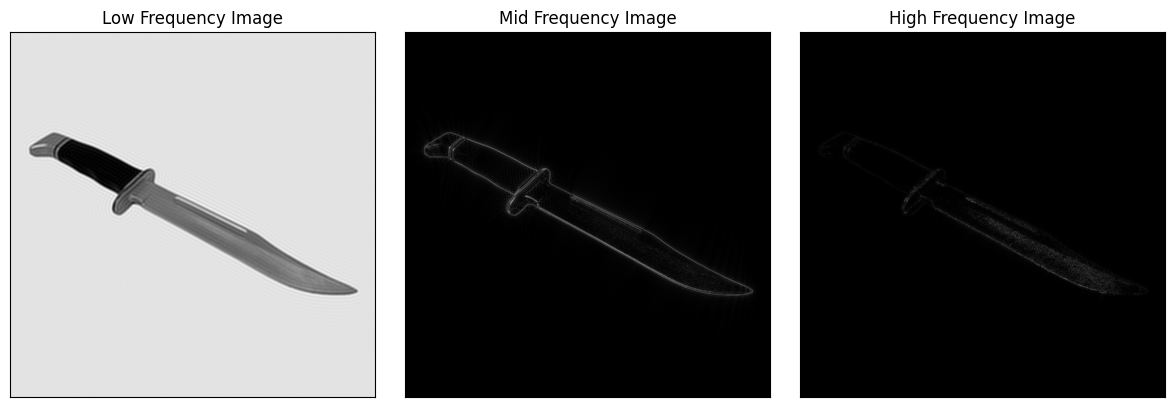

NoneType

In [18]:
visualize_filtered_dft("images/knife.jpg")

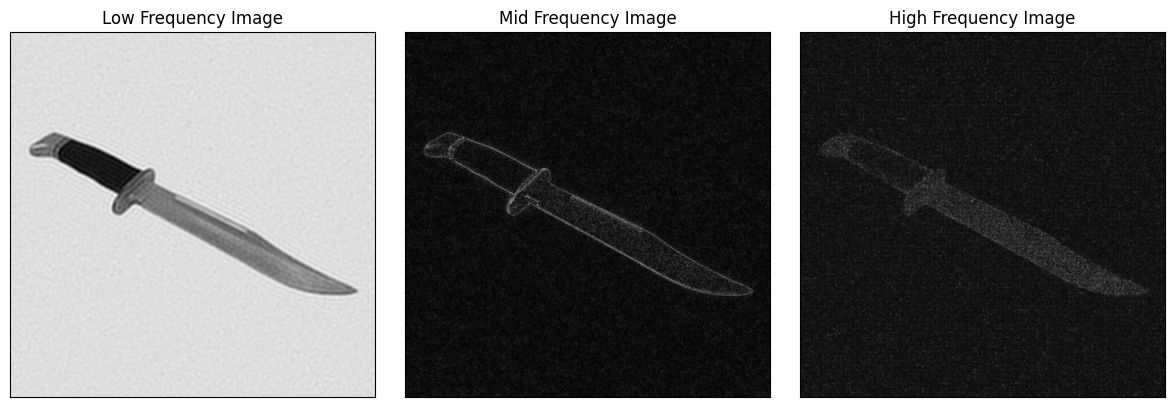

In [19]:
visualize_filtered_dft("images/knife_attacked.png")

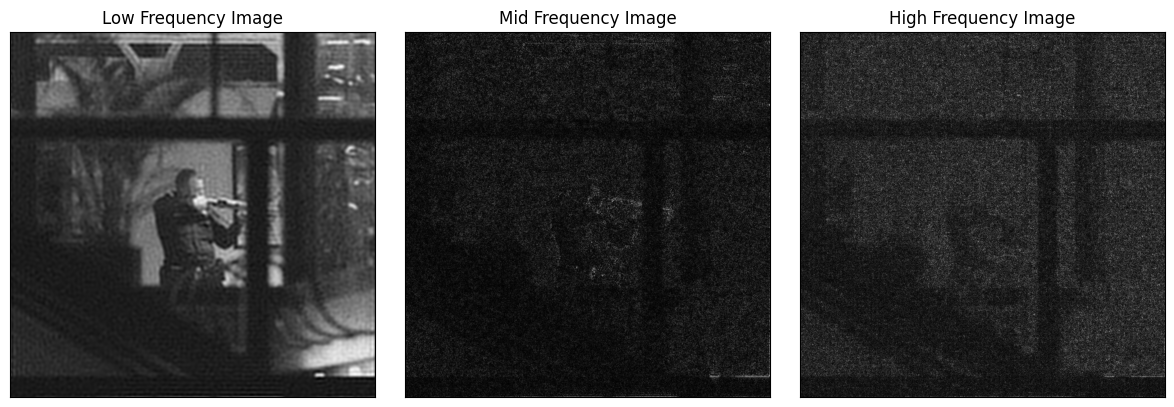

In [23]:
image_file_path = 'images/gunman2_attacked.png' 
visualize_filtered_dft(image_file_path)

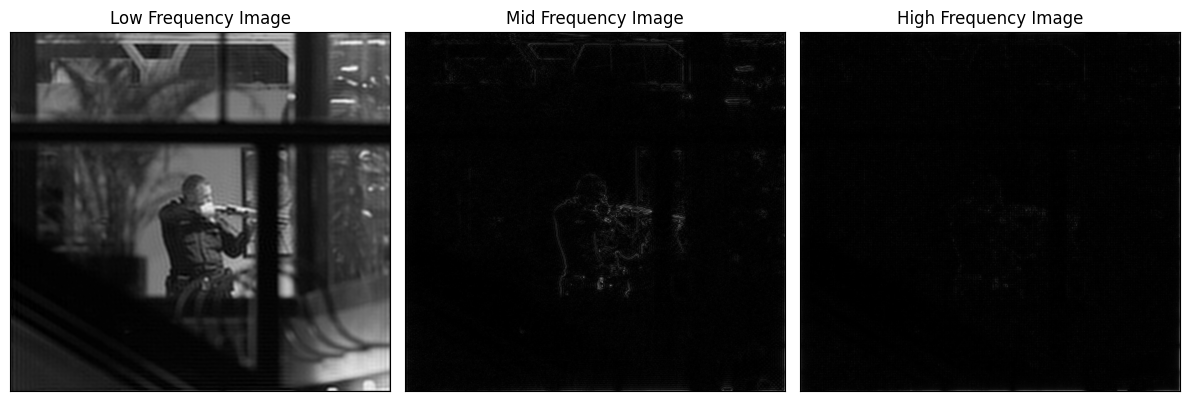

In [24]:
image_file_path = 'images/gunman2.jpg'
visualize_filtered_dft(image_file_path)

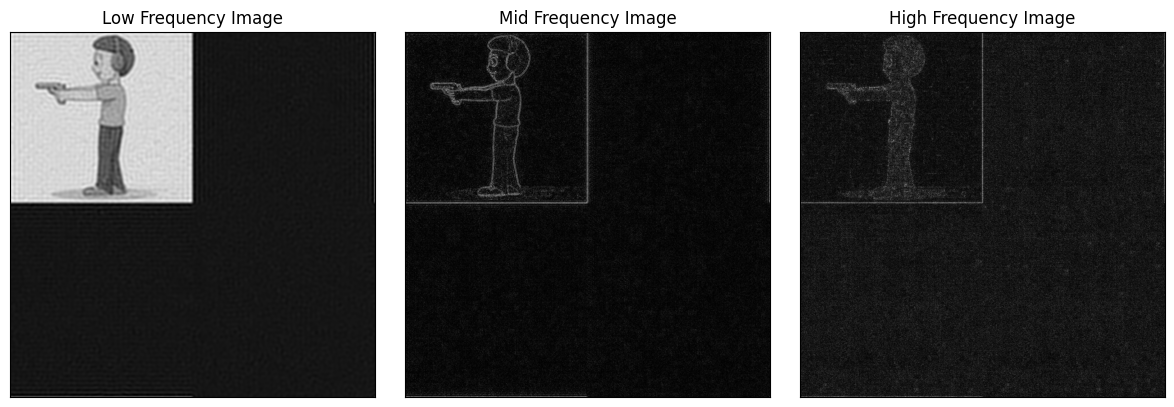

In [25]:
image_file_path = 'images/gunman3_attacked.png' 
visualize_filtered_dft(image_file_path)

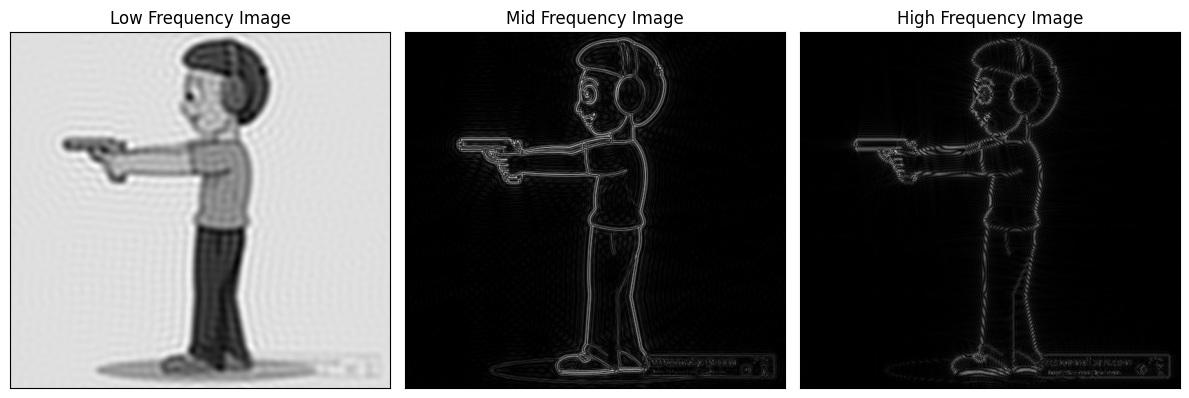

In [27]:
image_file_path = 'images/gunman3.jpg' 
visualize_filtered_dft(image_file_path)